# Exploring U-Net Activations

> This notebook covers the necessary steps to experiment with a simple U-Net architecture, visualizing its activations.

We will approach the following:

- Defining a simple U-Net model for semantic segmentation of parasites;
- Defining a Dataloader for model training, using torch `Dataset` and `DataLoader`;
- Saving U-Net activations for visualization;
- Computing metrics from the predicted segmentation masks.

## Dataset

Let us first define our dataset, we will explore the parasite egg dataset, towards 2D segmentation. The eggs are from Schistossoma Mansoni.

In [35]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

In [44]:
# The dataset path - Path to parasite images and labels
# reshaped to 240x240 pixels

data_path = Path("/home/afalcao/data/parasites/TFTestQuantified/exper")
orig_path = data_path / Path("orig")
labels_path = data_path / Path("label")

#data_path = Path("/home/john_doe/msc/2_datasets/parasites")
#orig_path = data_path / Path("all_images")
#labels_path = data_path / Path("all_truelabels")

In [45]:
# Method to plot original and label images 
def plot_image_with_label(image, label):
    image_path = orig_path / Path(image)
    label_path = labels_path / Path(label)
    
    image = Image.open(image_path)
    label = Image.open(label_path)
    
    print(f"[Image] Format: {image.format} | Size: {image.size} | Mode: {image.mode}")
    print(f"[Label] Format: {label.format} | Size: {label.size} | Mode: {label.mode}")
    
    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label, cmap="gray")
    

Our dataset contains 96 images. We will further divide it into training and testing images. We will use ~80% to train (76) and ~20% to test (20) the model.

[Image] Format: PNG | Size: (240, 240) | Mode: RGB
[Label] Format: PNG | Size: (240, 240) | Mode: L


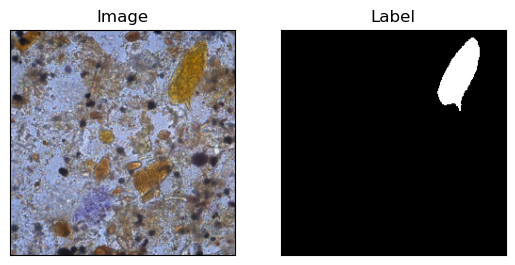

In [46]:
images = os.listdir(orig_path)
images.sort()
labels = images # Label images have the same filename of the originals
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]

# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

# Image idx to visualize
idx = 0
plot_image_with_label(train_images[idx], train_labels[idx])

## Dataset and Dataloader

Now, we need to define the Dataset and Dataloader classes. They must:

- Enable training and testing with a single image
- Enable training and testing using the data splits

In [47]:
# Necessary libraries
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

In [48]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """Transform input images to normalized tensors.
        [0, 255] -> [0, 1]
        """
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with all data
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.image_transforms(Image.open(image_path))
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)
        
        # Redefine the label image to have two prediction channels: 
        # the Background and Foreground channels.
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

In [49]:
# Dataset with all images
seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=images,
    labels=labels,
    image_id=0 # the image index for training and testing 
               # with a single image or use None for 
               # training and testing with the data split 
)

In [50]:
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    viz_array = np.zeros(shape=(img.shape[1], img.shape[2], img.shape[0]))
    viz_array[:, :, 0] = img[0, :, :]
    viz_array[:, :, 1] = img[1, :, :]
    viz_array[:, :, 2] = img[2, :, :]
    
    print("Foreground shape => ", img.shape)
    print("label shape => ", label.shape)
        
    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(viz_array)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")
    

Foreground shape =>  torch.Size([3, 240, 240])
label shape =>  torch.Size([2, 240, 240])


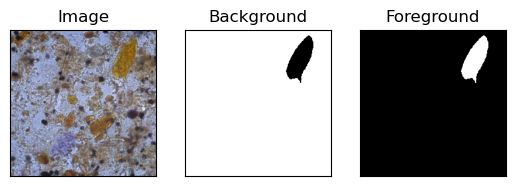

In [51]:
## Visualize image item (Given an ID)
visualize_dataset_item(seg_dataset, 0)

Now, let's define samples of a DataLoader. For training and testing with a single image, use batch size 1. Otherwise, use batch size 8.

In [52]:
# Example of defining a Dataloader (Single Image)

seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
sample_dataloader = DataLoader(seg_dataset, batch_size=1, shuffle=False)
sample_train_images, sample_train_labels = next(iter(sample_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)


Images shape =>  torch.Size([1, 3, 240, 240])
Labels shape =>  torch.Size([1, 2, 240, 240])


In [11]:
# Example of defining a Dataloader (using the data split)
'''
seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
sample_dataloader = DataLoader(seg_dataset, batch_size=8, shuffle=True)
sample_train_images, sample_train_labels = next(iter(sample_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)
'''

Images shape =>  torch.Size([8, 3, 2046, 4080])
Labels shape =>  torch.Size([8, 2, 2046, 4080])


## Model

Now, we define our U-Net model. We must enable it to store the activation maps for visual analysis.

In [53]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

In [54]:
# Utilitarians blocks for UNet Decoder

# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [55]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[0], stride=2,
                padding=kernel_sizes[0] // 2
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[1], stride=2,
                padding=kernel_sizes[1] // 2
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[2], stride=2,
                padding=kernel_sizes[2] // 2
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

In [56]:
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[7, 7, 7],
    bottleneck_size=3,
    activations_path=data_path / Path("test")
)

In [57]:
y = unet.forward(sample_train_images)
print(y.shape)

torch.Size([1, 2, 240, 240])


In [ ]:
# Uncomment this block to save model architecture to PNG

# Install hiddenlayer package (version without bug on graph tracing)
'''
!python -m pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git
import hiddenlayer as hl
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
graph = hl.build_graph(unet, train_images, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('unet_simple', format='png')
'''

## Finaly, we define and test our training loop

In [58]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

In [59]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
    "dice_focal": DiceFocalLoss()
}

class Loss(nn.Module):
    def __init__(
            self,
            loss_fn: Union[torch.nn.modules.loss, monai.losses],
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

In [60]:
# Finaly, we define and test our training loop
# Save activations every N epochs
N_SAVE_ACTIVATIONS = 200
def train_loop(epochs, model, dataloader, lr, loss_function, weights):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to("cuda")
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = nn.functional.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()

            loss_value.backward()
            optimizer.step()
        
        logger.record(
            epoch + 1,
            trn_loss=loss_value.item(),
            trn_accuracy=accuracy.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

We have defined the following architecture:

![](arch_sample.png)

EPOCH: 1.000  trn_loss: 1.366  trn_accuracy: 0.643  (1.35s - 673.33s remaining)
EPOCH: 2.000  trn_loss: 1.338  trn_accuracy: 0.721  (1.36s - 338.95s remaining)
EPOCH: 3.000  trn_loss: 1.317  trn_accuracy: 0.766  (1.37s - 227.26s remaining)
EPOCH: 4.000  trn_loss: 1.294  trn_accuracy: 0.821  (1.38s - 171.39s remaining)
EPOCH: 5.000  trn_loss: 1.271  trn_accuracy: 0.865  (1.39s - 137.85s remaining)
EPOCH: 6.000  trn_loss: 1.252  trn_accuracy: 0.891  (1.40s - 115.48s remaining)
EPOCH: 7.000  trn_loss: 1.234  trn_accuracy: 0.906  (1.41s - 99.53s remaining)
EPOCH: 8.000  trn_loss: 1.219  trn_accuracy: 0.919  (1.42s - 87.55s remaining)
EPOCH: 9.000  trn_loss: 1.205  trn_accuracy: 0.932  (1.43s - 78.23s remaining)
EPOCH: 10.000  trn_loss: 1.192  trn_accuracy: 0.941  (1.44s - 70.76s remaining)
EPOCH: 11.000  trn_loss: 1.179  trn_accuracy: 0.948  (1.45s - 64.64s remaining)
EPOCH: 12.000  trn_loss: 1.167  trn_accuracy: 0.954  (1.46s - 59.54s remaining)
EPOCH: 13.000  trn_loss: 1.155  trn_accurac

EPOCH: 109.000  trn_loss: 0.240  trn_accuracy: 0.968  (2.39s - 8.57s remaining)
EPOCH: 110.000  trn_loss: 0.236  trn_accuracy: 0.968  (2.40s - 8.51s remaining)
EPOCH: 111.000  trn_loss: 0.231  trn_accuracy: 0.968  (2.41s - 8.45s remaining)
EPOCH: 112.000  trn_loss: 0.227  trn_accuracy: 0.968  (2.42s - 8.38s remaining)
EPOCH: 113.000  trn_loss: 0.222  trn_accuracy: 0.968  (2.43s - 8.32s remaining)
EPOCH: 114.000  trn_loss: 0.218  trn_accuracy: 0.968  (2.44s - 8.26s remaining)
EPOCH: 115.000  trn_loss: 0.214  trn_accuracy: 0.968  (2.45s - 8.19s remaining)
EPOCH: 116.000  trn_loss: 0.210  trn_accuracy: 0.968  (2.46s - 8.13s remaining)
EPOCH: 117.000  trn_loss: 0.206  trn_accuracy: 0.968  (2.47s - 8.07s remaining)
EPOCH: 118.000  trn_loss: 0.202  trn_accuracy: 0.968  (2.47s - 8.01s remaining)
EPOCH: 119.000  trn_loss: 0.199  trn_accuracy: 0.968  (2.48s - 7.95s remaining)
EPOCH: 120.000  trn_loss: 0.195  trn_accuracy: 0.968  (2.49s - 7.89s remaining)
EPOCH: 121.000  trn_loss: 0.192  trn_acc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:16<00:00,  4.55it/s]


EPOCH: 201.000  trn_loss: 0.092  trn_accuracy: 0.968  (19.96s - 29.69s remaining)
EPOCH: 202.000  trn_loss: 0.092  trn_accuracy: 0.968  (19.97s - 29.46s remaining)
EPOCH: 203.000  trn_loss: 0.091  trn_accuracy: 0.968  (19.98s - 29.23s remaining)
EPOCH: 204.000  trn_loss: 0.091  trn_accuracy: 0.968  (19.99s - 29.01s remaining)
EPOCH: 205.000  trn_loss: 0.091  trn_accuracy: 0.968  (20.00s - 28.79s remaining)
EPOCH: 206.000  trn_loss: 0.090  trn_accuracy: 0.968  (20.01s - 28.56s remaining)
EPOCH: 207.000  trn_loss: 0.090  trn_accuracy: 0.968  (20.02s - 28.34s remaining)
EPOCH: 208.000  trn_loss: 0.090  trn_accuracy: 0.968  (20.03s - 28.12s remaining)
EPOCH: 209.000  trn_loss: 0.089  trn_accuracy: 0.968  (20.04s - 27.91s remaining)
EPOCH: 210.000  trn_loss: 0.089  trn_accuracy: 0.968  (20.05s - 27.69s remaining)
EPOCH: 211.000  trn_loss: 0.089  trn_accuracy: 0.968  (20.06s - 27.48s remaining)
EPOCH: 212.000  trn_loss: 0.088  trn_accuracy: 0.968  (20.08s - 27.27s remaining)
EPOCH: 213.000  

EPOCH: 304.000  trn_loss: 0.071  trn_accuracy: 0.968  (20.98s - 13.53s remaining)
EPOCH: 305.000  trn_loss: 0.071  trn_accuracy: 0.968  (20.99s - 13.42s remaining)
EPOCH: 306.000  trn_loss: 0.071  trn_accuracy: 0.968  (21.00s - 13.32s remaining)
EPOCH: 307.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.01s - 13.21s remaining)
EPOCH: 308.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.02s - 13.10s remaining)
EPOCH: 309.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.03s - 13.00s remaining)
EPOCH: 310.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.04s - 12.90s remaining)
EPOCH: 311.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.05s - 12.79s remaining)
EPOCH: 312.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.06s - 12.69s remaining)
EPOCH: 313.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.07s - 12.59s remaining)
EPOCH: 314.000  trn_loss: 0.070  trn_accuracy: 0.968  (21.08s - 12.49s remaining)
EPOCH: 315.000  trn_loss: 0.069  trn_accuracy: 0.968  (21.09s - 12.39s remaining)
EPOCH: 316.000  

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:14<00:00,  5.23it/s]


EPOCH: 401.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.41s - 8.99s remaining)
EPOCH: 402.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.42s - 8.88s remaining)
EPOCH: 403.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.43s - 8.77s remaining)
EPOCH: 404.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.44s - 8.66s remaining)
EPOCH: 405.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.45s - 8.55s remaining)
EPOCH: 406.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.46s - 8.44s remaining)
EPOCH: 407.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.47s - 8.33s remaining)
EPOCH: 408.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.48s - 8.23s remaining)
EPOCH: 409.000  trn_loss: 0.063  trn_accuracy: 0.968  (36.49s - 8.12s remaining)
EPOCH: 410.000  trn_loss: 0.062  trn_accuracy: 0.968  (36.50s - 8.01s remaining)
EPOCH: 411.000  trn_loss: 0.062  trn_accuracy: 0.968  (36.51s - 7.91s remaining)
EPOCH: 412.000  trn_loss: 0.062  trn_accuracy: 0.968  (36.52s - 7.80s remaining)
EPOCH: 413.000  trn_loss: 0.

100%|█████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 29089.47it/s]


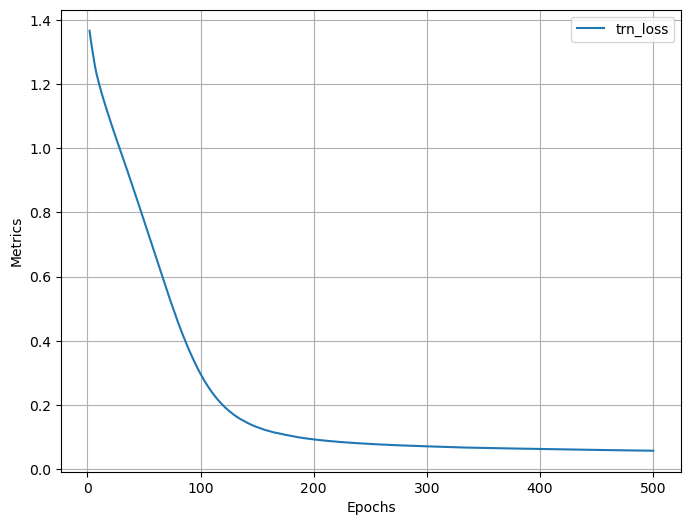

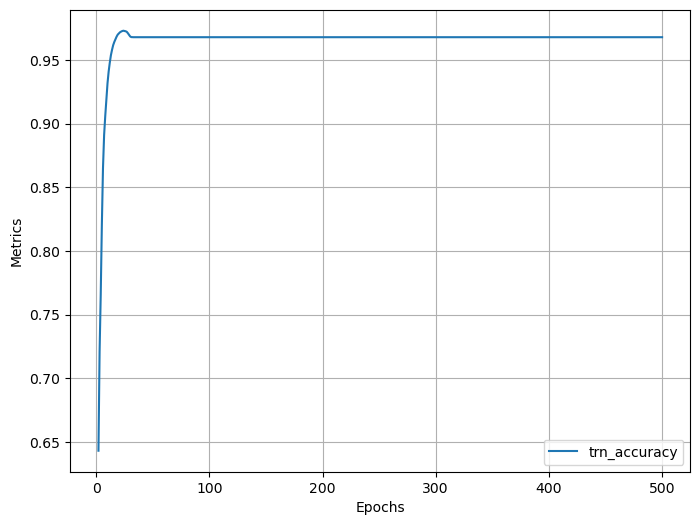

In [61]:
# SET ACTIVATIONS PATH TO EXPORT ENCODER/DECODER ACTIVATIONS AND LEARNING CURVES
kernel_size = 7

unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_dice_focal_fulldata".format(kernel_size))
)

train_loop(
    epochs=500,
    model=unet,
    dataloader=sample_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)

Finally, we define a method to use our trained model and predict a segmentation map. We also compute metrics between the prediction map and the ground-truth.

In [62]:
from medpy.metric import binary
np.bool = np.bool_

In [63]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(Image.open(image_path))
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data)
        prediction = nn.functional.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        dice = binary.dc(mask, ground_truth)
        dices.append(dice)
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")

In [64]:
predict_and_evaluate(model=unet, data_loader=sample_dataloader)

76it [00:00, 204.92it/s]

[INFO] Avg Accuracy: 0.9879982471466064 +/- 0.011624940671026707
[INFO] Avg Dice: 0.0 +/- 0.0


Now, let us run 3 experiments to verify how U-Net tackles training with different ammount of data:

- First, we train our network on only one image and then evaluate it on test set;
- Then, we train our network on all training images and evaluate it on test set;
- Finnaly, we train it on ~10% of our training data (7 images) and evaluate it on test set.

___

# Training with a single image

EPOCH: 1.000  trn_loss: 1.546  trn_accuracy: 0.130  (0.06s - 57.07s remaining)
EPOCH: 2.000  trn_loss: 1.521  trn_accuracy: 0.137  (0.07s - 32.83s remaining)
EPOCH: 3.000  trn_loss: 1.497  trn_accuracy: 0.145  (0.07s - 24.29s remaining)
EPOCH: 4.000  trn_loss: 1.481  trn_accuracy: 0.159  (0.08s - 19.86s remaining)
EPOCH: 5.000  trn_loss: 1.466  trn_accuracy: 0.187  (0.09s - 17.10s remaining)
EPOCH: 6.000  trn_loss: 1.455  trn_accuracy: 0.398  (0.09s - 15.26s remaining)
EPOCH: 7.000  trn_loss: 1.444  trn_accuracy: 0.441  (0.10s - 13.93s remaining)
EPOCH: 8.000  trn_loss: 1.435  trn_accuracy: 0.479  (0.10s - 12.96s remaining)
EPOCH: 9.000  trn_loss: 1.427  trn_accuracy: 0.517  (0.11s - 12.21s remaining)
EPOCH: 10.000  trn_loss: 1.419  trn_accuracy: 0.553  (0.12s - 11.58s remaining)
EPOCH: 11.000  trn_loss: 1.412  trn_accuracy: 0.587  (0.12s - 11.10s remaining)
EPOCH: 12.000  trn_loss: 1.407  trn_accuracy: 0.618  (0.13s - 10.68s remaining)
EPOCH: 13.000  trn_loss: 1.402  trn_accuracy: 0.6

EPOCH: 132.000  trn_loss: 0.889  trn_accuracy: 0.968  (0.87s - 5.75s remaining)
EPOCH: 133.000  trn_loss: 0.883  trn_accuracy: 0.968  (0.88s - 5.74s remaining)
EPOCH: 134.000  trn_loss: 0.877  trn_accuracy: 0.968  (0.89s - 5.73s remaining)
EPOCH: 135.000  trn_loss: 0.871  trn_accuracy: 0.968  (0.89s - 5.72s remaining)
EPOCH: 136.000  trn_loss: 0.865  trn_accuracy: 0.968  (0.90s - 5.71s remaining)
EPOCH: 137.000  trn_loss: 0.859  trn_accuracy: 0.968  (0.91s - 5.70s remaining)
EPOCH: 138.000  trn_loss: 0.852  trn_accuracy: 0.968  (0.91s - 5.70s remaining)
EPOCH: 139.000  trn_loss: 0.847  trn_accuracy: 0.968  (0.92s - 5.68s remaining)
EPOCH: 140.000  trn_loss: 0.841  trn_accuracy: 0.968  (0.92s - 5.68s remaining)
EPOCH: 141.000  trn_loss: 0.834  trn_accuracy: 0.968  (0.93s - 5.67s remaining)
EPOCH: 142.000  trn_loss: 0.828  trn_accuracy: 0.968  (0.94s - 5.66s remaining)
EPOCH: 143.000  trn_loss: 0.822  trn_accuracy: 0.968  (0.94s - 5.65s remaining)
EPOCH: 144.000  trn_loss: 0.816  trn_acc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:06<00:00, 10.87it/s]


EPOCH: 201.000  trn_loss: 0.486  trn_accuracy: 0.968  (8.38s - 33.33s remaining)
EPOCH: 202.000  trn_loss: 0.481  trn_accuracy: 0.968  (8.39s - 33.15s remaining)
EPOCH: 203.000  trn_loss: 0.477  trn_accuracy: 0.968  (8.40s - 32.97s remaining)
EPOCH: 204.000  trn_loss: 0.473  trn_accuracy: 0.968  (8.40s - 32.79s remaining)
EPOCH: 205.000  trn_loss: 0.469  trn_accuracy: 0.968  (8.41s - 32.61s remaining)
EPOCH: 206.000  trn_loss: 0.465  trn_accuracy: 0.968  (8.42s - 32.44s remaining)
EPOCH: 207.000  trn_loss: 0.461  trn_accuracy: 0.968  (8.42s - 32.26s remaining)
EPOCH: 208.000  trn_loss: 0.457  trn_accuracy: 0.968  (8.43s - 32.09s remaining)
EPOCH: 209.000  trn_loss: 0.453  trn_accuracy: 0.968  (8.43s - 31.92s remaining)
EPOCH: 210.000  trn_loss: 0.450  trn_accuracy: 0.968  (8.44s - 31.75s remaining)
EPOCH: 211.000  trn_loss: 0.446  trn_accuracy: 0.968  (8.45s - 31.59s remaining)
EPOCH: 212.000  trn_loss: 0.442  trn_accuracy: 0.968  (8.45s - 31.42s remaining)
EPOCH: 213.000  trn_loss: 0.

EPOCH: 328.000  trn_loss: 0.269  trn_accuracy: 0.968  (9.20s - 18.85s remaining)
EPOCH: 329.000  trn_loss: 0.269  trn_accuracy: 0.968  (9.21s - 18.78s remaining)
EPOCH: 330.000  trn_loss: 0.268  trn_accuracy: 0.968  (9.21s - 18.70s remaining)
EPOCH: 331.000  trn_loss: 0.268  trn_accuracy: 0.968  (9.22s - 18.63s remaining)
EPOCH: 332.000  trn_loss: 0.267  trn_accuracy: 0.968  (9.23s - 18.56s remaining)
EPOCH: 333.000  trn_loss: 0.267  trn_accuracy: 0.968  (9.23s - 18.49s remaining)
EPOCH: 334.000  trn_loss: 0.266  trn_accuracy: 0.968  (9.24s - 18.42s remaining)
EPOCH: 335.000  trn_loss: 0.266  trn_accuracy: 0.968  (9.24s - 18.35s remaining)
EPOCH: 336.000  trn_loss: 0.265  trn_accuracy: 0.968  (9.25s - 18.28s remaining)
EPOCH: 337.000  trn_loss: 0.265  trn_accuracy: 0.968  (9.26s - 18.21s remaining)
EPOCH: 338.000  trn_loss: 0.264  trn_accuracy: 0.968  (9.26s - 18.14s remaining)
EPOCH: 339.000  trn_loss: 0.264  trn_accuracy: 0.968  (9.27s - 18.07s remaining)
EPOCH: 340.000  trn_loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:05<00:00, 12.92it/s]


EPOCH: 401.000  trn_loss: 0.167  trn_accuracy: 0.968  (15.54s - 23.22s remaining)
EPOCH: 402.000  trn_loss: 0.166  trn_accuracy: 0.968  (15.55s - 23.13s remaining)
EPOCH: 403.000  trn_loss: 0.164  trn_accuracy: 0.968  (15.56s - 23.05s remaining)
EPOCH: 404.000  trn_loss: 0.163  trn_accuracy: 0.968  (15.57s - 22.97s remaining)
EPOCH: 405.000  trn_loss: 0.162  trn_accuracy: 0.968  (15.58s - 22.89s remaining)
EPOCH: 406.000  trn_loss: 0.161  trn_accuracy: 0.968  (15.59s - 22.81s remaining)
EPOCH: 407.000  trn_loss: 0.160  trn_accuracy: 0.968  (15.60s - 22.73s remaining)
EPOCH: 408.000  trn_loss: 0.159  trn_accuracy: 0.968  (15.61s - 22.65s remaining)
EPOCH: 409.000  trn_loss: 0.158  trn_accuracy: 0.968  (15.62s - 22.57s remaining)
EPOCH: 410.000  trn_loss: 0.157  trn_accuracy: 0.968  (15.63s - 22.49s remaining)
EPOCH: 411.000  trn_loss: 0.155  trn_accuracy: 0.968  (15.64s - 22.42s remaining)
EPOCH: 412.000  trn_loss: 0.154  trn_accuracy: 0.968  (15.65s - 22.34s remaining)
EPOCH: 413.000  

EPOCH: 528.000  trn_loss: 0.097  trn_accuracy: 0.968  (16.57s - 14.81s remaining)
EPOCH: 529.000  trn_loss: 0.097  trn_accuracy: 0.968  (16.58s - 14.76s remaining)
EPOCH: 530.000  trn_loss: 0.097  trn_accuracy: 0.968  (16.58s - 14.71s remaining)
EPOCH: 531.000  trn_loss: 0.097  trn_accuracy: 0.968  (16.59s - 14.65s remaining)
EPOCH: 532.000  trn_loss: 0.097  trn_accuracy: 0.968  (16.59s - 14.60s remaining)
EPOCH: 533.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.60s - 14.55s remaining)
EPOCH: 534.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.61s - 14.49s remaining)
EPOCH: 535.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.62s - 14.44s remaining)
EPOCH: 536.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.62s - 14.39s remaining)
EPOCH: 537.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.63s - 14.34s remaining)
EPOCH: 538.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.64s - 14.29s remaining)
EPOCH: 539.000  trn_loss: 0.096  trn_accuracy: 0.968  (16.65s - 14.24s remaining)
EPOCH: 540.000  

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:05<00:00, 14.61it/s]


EPOCH: 601.000  trn_loss: 0.090  trn_accuracy: 0.968  (22.38s - 14.86s remaining)
EPOCH: 602.000  trn_loss: 0.090  trn_accuracy: 0.968  (22.39s - 14.80s remaining)
EPOCH: 603.000  trn_loss: 0.090  trn_accuracy: 0.968  (22.39s - 14.74s remaining)
EPOCH: 604.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.40s - 14.69s remaining)
EPOCH: 605.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.41s - 14.63s remaining)
EPOCH: 606.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.41s - 14.57s remaining)
EPOCH: 607.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.42s - 14.51s remaining)
EPOCH: 608.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.43s - 14.46s remaining)
EPOCH: 609.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.43s - 14.40s remaining)
EPOCH: 610.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.44s - 14.35s remaining)
EPOCH: 611.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.45s - 14.29s remaining)
EPOCH: 612.000  trn_loss: 0.089  trn_accuracy: 0.968  (22.45s - 14.24s remaining)
EPOCH: 613.000  

EPOCH: 708.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.32s - 9.62s remaining)
EPOCH: 709.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.33s - 9.58s remaining)
EPOCH: 710.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.34s - 9.53s remaining)
EPOCH: 711.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.34s - 9.49s remaining)
EPOCH: 712.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.35s - 9.45s remaining)
EPOCH: 713.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.36s - 9.40s remaining)
EPOCH: 714.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.36s - 9.36s remaining)
EPOCH: 715.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.37s - 9.32s remaining)
EPOCH: 716.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.38s - 9.27s remaining)
EPOCH: 717.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.38s - 9.23s remaining)
EPOCH: 718.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.39s - 9.19s remaining)
EPOCH: 719.000  trn_loss: 0.083  trn_accuracy: 0.968  (23.39s - 9.14s remaining)
EPOCH: 720.000  trn_loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:05<00:00, 14.69it/s]


EPOCH: 801.000  trn_loss: 0.079  trn_accuracy: 0.968  (29.08s - 7.22s remaining)
EPOCH: 802.000  trn_loss: 0.079  trn_accuracy: 0.968  (29.08s - 7.18s remaining)
EPOCH: 803.000  trn_loss: 0.079  trn_accuracy: 0.968  (29.09s - 7.14s remaining)
EPOCH: 804.000  trn_loss: 0.079  trn_accuracy: 0.968  (29.10s - 7.09s remaining)
EPOCH: 805.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.10s - 7.05s remaining)
EPOCH: 806.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.11s - 7.01s remaining)
EPOCH: 807.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.11s - 6.96s remaining)
EPOCH: 808.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.12s - 6.92s remaining)
EPOCH: 809.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.13s - 6.88s remaining)
EPOCH: 810.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.13s - 6.83s remaining)
EPOCH: 811.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.14s - 6.79s remaining)
EPOCH: 812.000  trn_loss: 0.078  trn_accuracy: 0.968  (29.14s - 6.75s remaining)
EPOCH: 813.000  trn_loss: 0.

EPOCH: 933.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.89s - 2.15s remaining)
EPOCH: 934.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.90s - 2.11s remaining)
EPOCH: 935.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.90s - 2.08s remaining)
EPOCH: 936.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.91s - 2.05s remaining)
EPOCH: 937.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.92s - 2.01s remaining)
EPOCH: 938.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.92s - 1.98s remaining)
EPOCH: 939.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.93s - 1.94s remaining)
EPOCH: 940.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.93s - 1.91s remaining)
EPOCH: 941.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.94s - 1.88s remaining)
EPOCH: 942.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.94s - 1.84s remaining)
EPOCH: 943.000  trn_loss: 0.073  trn_accuracy: 0.968  (29.95s - 1.81s remaining)
EPOCH: 944.000  trn_loss: 0.072  trn_accuracy: 0.968  (29.96s - 1.78s remaining)
EPOCH: 945.000  trn_loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 35258.90it/s]
20it [00:00, 196.67it/s]


[INFO] Avg Accuracy: 0.9879522323608398 +/- 0.012367559596896172
[INFO] Avg Dice: 0.0 +/- 0.0


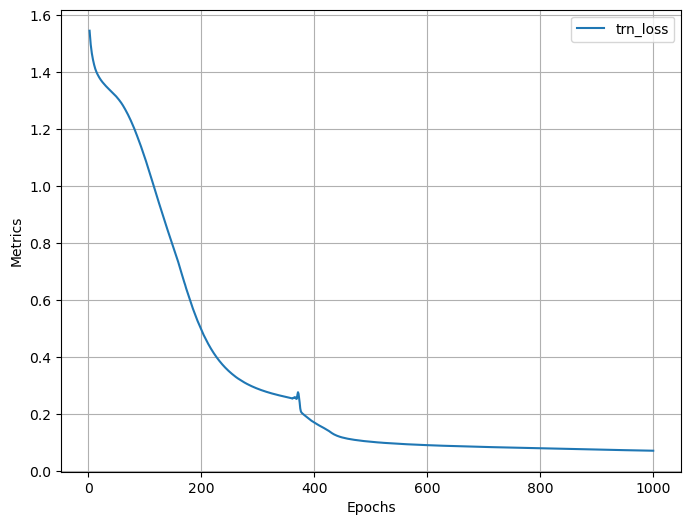

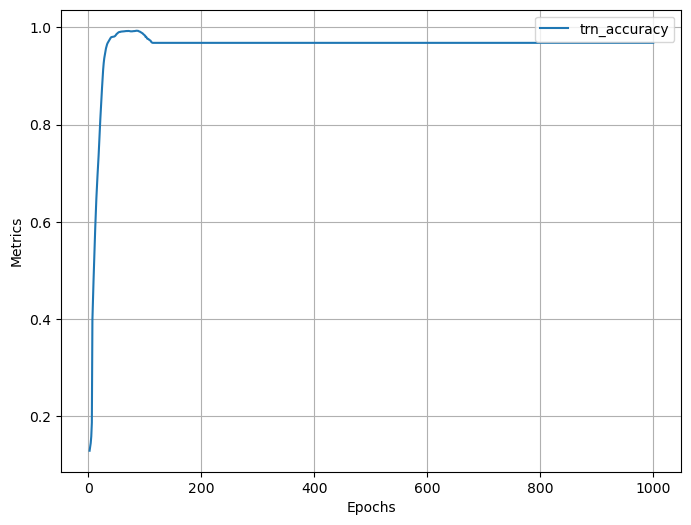

In [65]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_one_image".format(kernel_size))
)


train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
predict_and_evaluate(model=unet, data_loader=test_dataloader)

# Training with the data split

EPOCH: 1.000  trn_loss: 1.709  trn_accuracy: 0.834  (0.32s - 316.16s remaining)
EPOCH: 2.000  trn_loss: 1.693  trn_accuracy: 0.872  (0.59s - 292.71s remaining)
EPOCH: 3.000  trn_loss: 1.669  trn_accuracy: 0.889  (0.86s - 285.15s remaining)
EPOCH: 4.000  trn_loss: 1.657  trn_accuracy: 0.909  (1.13s - 280.56s remaining)
EPOCH: 5.000  trn_loss: 1.656  trn_accuracy: 0.931  (1.40s - 277.61s remaining)
EPOCH: 6.000  trn_loss: 1.646  trn_accuracy: 0.943  (1.67s - 275.84s remaining)
EPOCH: 7.000  trn_loss: 1.628  trn_accuracy: 0.949  (1.97s - 279.61s remaining)
EPOCH: 8.000  trn_loss: 1.622  trn_accuracy: 0.959  (2.24s - 277.66s remaining)
EPOCH: 9.000  trn_loss: 1.615  trn_accuracy: 0.967  (2.50s - 275.40s remaining)
EPOCH: 10.000  trn_loss: 1.613  trn_accuracy: 0.976  (2.77s - 274.21s remaining)
EPOCH: 11.000  trn_loss: 1.610  trn_accuracy: 0.983  (3.03s - 272.67s remaining)
EPOCH: 12.000  trn_loss: 1.598  trn_accuracy: 0.982  (3.31s - 272.25s remaining)
EPOCH: 13.000  trn_loss: 1.580  trn_a

EPOCH: 102.000  trn_loss: 1.220  trn_accuracy: 0.989  (33.72s - 296.90s remaining)
EPOCH: 103.000  trn_loss: 1.218  trn_accuracy: 0.988  (34.08s - 296.75s remaining)
EPOCH: 104.000  trn_loss: 1.210  trn_accuracy: 0.985  (34.43s - 296.62s remaining)
EPOCH: 105.000  trn_loss: 1.209  trn_accuracy: 0.991  (34.78s - 296.48s remaining)
EPOCH: 106.000  trn_loss: 1.203  trn_accuracy: 0.986  (35.13s - 296.32s remaining)
EPOCH: 107.000  trn_loss: 1.177  trn_accuracy: 0.982  (35.49s - 296.18s remaining)
EPOCH: 108.000  trn_loss: 1.211  trn_accuracy: 0.990  (35.84s - 296.05s remaining)
EPOCH: 109.000  trn_loss: 1.197  trn_accuracy: 0.986  (36.20s - 295.89s remaining)
EPOCH: 110.000  trn_loss: 1.175  trn_accuracy: 0.978  (36.55s - 295.73s remaining)
EPOCH: 111.000  trn_loss: 1.183  trn_accuracy: 0.986  (36.91s - 295.59s remaining)
EPOCH: 112.000  trn_loss: 1.156  trn_accuracy: 0.975  (37.26s - 295.43s remaining)
EPOCH: 113.000  trn_loss: 1.188  trn_accuracy: 0.986  (37.61s - 295.26s remaining)
EPOC

100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:17<00:00,  4.32it/s]


EPOCH: 201.000  trn_loss: 1.139  trn_accuracy: 0.983  (85.90s - 341.46s remaining)
EPOCH: 202.000  trn_loss: 1.157  trn_accuracy: 0.988  (86.17s - 340.41s remaining)
EPOCH: 203.000  trn_loss: 1.176  trn_accuracy: 0.994  (86.47s - 339.49s remaining)
EPOCH: 204.000  trn_loss: 1.206  trn_accuracy: 1.000  (86.82s - 338.78s remaining)
EPOCH: 205.000  trn_loss: 1.167  trn_accuracy: 0.990  (87.18s - 338.08s remaining)
EPOCH: 206.000  trn_loss: 1.172  trn_accuracy: 0.993  (87.53s - 337.37s remaining)
EPOCH: 207.000  trn_loss: 1.108  trn_accuracy: 0.975  (87.88s - 336.67s remaining)
EPOCH: 208.000  trn_loss: 1.165  trn_accuracy: 0.992  (88.23s - 335.97s remaining)
EPOCH: 209.000  trn_loss: 1.169  trn_accuracy: 0.993  (88.59s - 335.29s remaining)
EPOCH: 210.000  trn_loss: 1.180  trn_accuracy: 0.993  (88.94s - 334.60s remaining)
EPOCH: 211.000  trn_loss: 1.181  trn_accuracy: 0.994  (89.30s - 333.91s remaining)
EPOCH: 212.000  trn_loss: 1.147  trn_accuracy: 0.990  (89.65s - 333.22s remaining)
EPOC

EPOCH: 300.000  trn_loss: 1.154  trn_accuracy: 0.990  (117.05s - 273.11s remaining)
EPOCH: 301.000  trn_loss: 1.147  trn_accuracy: 0.992  (117.40s - 272.64s remaining)
EPOCH: 302.000  trn_loss: 1.179  trn_accuracy: 0.994  (117.76s - 272.17s remaining)
EPOCH: 303.000  trn_loss: 1.171  trn_accuracy: 0.991  (118.11s - 271.69s remaining)
EPOCH: 304.000  trn_loss: 1.147  trn_accuracy: 0.990  (118.44s - 271.16s remaining)
EPOCH: 305.000  trn_loss: 1.199  trn_accuracy: 1.000  (118.73s - 270.56s remaining)
EPOCH: 306.000  trn_loss: 1.112  trn_accuracy: 0.987  (119.08s - 270.08s remaining)
EPOCH: 307.000  trn_loss: 1.111  trn_accuracy: 0.979  (119.43s - 269.59s remaining)
EPOCH: 308.000  trn_loss: 1.137  trn_accuracy: 0.986  (119.78s - 269.12s remaining)
EPOCH: 309.000  trn_loss: 1.108  trn_accuracy: 0.984  (120.13s - 268.64s remaining)
EPOCH: 310.000  trn_loss: 1.135  trn_accuracy: 0.990  (120.48s - 268.16s remaining)
EPOCH: 311.000  trn_loss: 1.142  trn_accuracy: 0.992  (120.83s - 267.69s rem

EPOCH: 398.000  trn_loss: 1.125  trn_accuracy: 0.984  (151.16s - 228.64s remaining)
EPOCH: 399.000  trn_loss: 1.154  trn_accuracy: 0.993  (151.50s - 228.20s remaining)
EPOCH: 400.000  trn_loss: 1.123  trn_accuracy: 0.984  (151.85s - 227.78s remaining)
[INFO] Saving activations!


100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:16<00:00,  4.49it/s]


EPOCH: 401.000  trn_loss: 1.121  trn_accuracy: 0.988  (169.06s - 252.53s remaining)
EPOCH: 402.000  trn_loss: 1.197  trn_accuracy: 1.000  (169.32s - 251.87s remaining)
EPOCH: 403.000  trn_loss: 1.153  trn_accuracy: 0.993  (169.66s - 251.34s remaining)
EPOCH: 404.000  trn_loss: 1.117  trn_accuracy: 0.987  (170.01s - 250.81s remaining)
EPOCH: 405.000  trn_loss: 1.130  trn_accuracy: 0.987  (170.36s - 250.28s remaining)
EPOCH: 406.000  trn_loss: 1.178  trn_accuracy: 0.996  (170.71s - 249.76s remaining)
EPOCH: 407.000  trn_loss: 1.056  trn_accuracy: 0.977  (171.06s - 249.24s remaining)
EPOCH: 408.000  trn_loss: 1.178  trn_accuracy: 0.994  (171.42s - 248.72s remaining)
EPOCH: 409.000  trn_loss: 1.197  trn_accuracy: 1.000  (171.77s - 248.21s remaining)
EPOCH: 410.000  trn_loss: 1.132  trn_accuracy: 0.991  (172.12s - 247.69s remaining)
EPOCH: 411.000  trn_loss: 1.133  trn_accuracy: 0.987  (172.48s - 247.17s remaining)
EPOCH: 412.000  trn_loss: 1.111  trn_accuracy: 0.989  (172.83s - 246.66s rem

EPOCH: 499.000  trn_loss: 1.054  trn_accuracy: 0.999  (202.71s - 203.52s remaining)
EPOCH: 500.000  trn_loss: 1.117  trn_accuracy: 0.999  (202.98s - 202.98s remaining)
EPOCH: 501.000  trn_loss: 1.129  trn_accuracy: 0.999  (203.25s - 202.44s remaining)
EPOCH: 502.000  trn_loss: 1.152  trn_accuracy: 0.999  (203.52s - 201.90s remaining)
EPOCH: 503.000  trn_loss: 1.093  trn_accuracy: 0.999  (203.79s - 201.36s remaining)
EPOCH: 504.000  trn_loss: 1.136  trn_accuracy: 0.999  (204.06s - 200.82s remaining)
EPOCH: 505.000  trn_loss: 1.163  trn_accuracy: 1.000  (204.33s - 200.28s remaining)
EPOCH: 506.000  trn_loss: 1.061  trn_accuracy: 0.999  (204.60s - 199.74s remaining)
EPOCH: 507.000  trn_loss: 1.115  trn_accuracy: 0.999  (204.86s - 199.20s remaining)
EPOCH: 508.000  trn_loss: 1.116  trn_accuracy: 0.999  (205.13s - 198.67s remaining)
EPOCH: 509.000  trn_loss: 1.128  trn_accuracy: 0.999  (205.40s - 198.14s remaining)
EPOCH: 510.000  trn_loss: 1.055  trn_accuracy: 0.999  (205.67s - 197.60s rem

EPOCH: 597.000  trn_loss: 0.711  trn_accuracy: 0.999  (232.75s - 157.12s remaining)
EPOCH: 598.000  trn_loss: 0.726  trn_accuracy: 0.999  (233.10s - 156.70s remaining)
EPOCH: 599.000  trn_loss: 0.755  trn_accuracy: 0.999  (233.45s - 156.28s remaining)
EPOCH: 600.000  trn_loss: 0.788  trn_accuracy: 1.000  (233.80s - 155.87s remaining)
[INFO] Saving activations!


100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:16<00:00,  4.58it/s]


EPOCH: 601.000  trn_loss: 0.757  trn_accuracy: 1.000  (250.74s - 166.47s remaining)
EPOCH: 602.000  trn_loss: 0.755  trn_accuracy: 0.999  (251.09s - 166.01s remaining)
EPOCH: 603.000  trn_loss: 0.755  trn_accuracy: 0.999  (251.45s - 165.55s remaining)
EPOCH: 604.000  trn_loss: 0.798  trn_accuracy: 0.999  (251.80s - 165.09s remaining)
EPOCH: 605.000  trn_loss: 0.676  trn_accuracy: 0.998  (252.15s - 164.63s remaining)
EPOCH: 606.000  trn_loss: 0.745  trn_accuracy: 0.999  (252.46s - 164.14s remaining)
EPOCH: 607.000  trn_loss: 0.735  trn_accuracy: 0.999  (252.74s - 163.64s remaining)
EPOCH: 608.000  trn_loss: 0.756  trn_accuracy: 0.999  (253.01s - 163.13s remaining)
EPOCH: 609.000  trn_loss: 0.695  trn_accuracy: 0.999  (253.28s - 162.61s remaining)
EPOCH: 610.000  trn_loss: 0.777  trn_accuracy: 0.999  (253.60s - 162.14s remaining)
EPOCH: 611.000  trn_loss: 0.734  trn_accuracy: 0.999  (253.95s - 161.68s remaining)
EPOCH: 612.000  trn_loss: 0.692  trn_accuracy: 0.999  (254.29s - 161.22s rem

EPOCH: 699.000  trn_loss: 0.212  trn_accuracy: 1.000  (281.80s - 121.35s remaining)
EPOCH: 700.000  trn_loss: 0.237  trn_accuracy: 0.999  (282.07s - 120.89s remaining)
EPOCH: 701.000  trn_loss: 0.258  trn_accuracy: 0.999  (282.34s - 120.43s remaining)
EPOCH: 702.000  trn_loss: 0.215  trn_accuracy: 1.000  (282.60s - 119.97s remaining)
EPOCH: 703.000  trn_loss: 0.220  trn_accuracy: 1.000  (282.88s - 119.51s remaining)
EPOCH: 704.000  trn_loss: 0.235  trn_accuracy: 0.999  (283.24s - 119.09s remaining)
EPOCH: 705.000  trn_loss: 0.223  trn_accuracy: 0.999  (283.56s - 118.65s remaining)
EPOCH: 706.000  trn_loss: 0.252  trn_accuracy: 0.999  (283.84s - 118.20s remaining)
EPOCH: 707.000  trn_loss: 0.241  trn_accuracy: 0.999  (284.19s - 117.78s remaining)
EPOCH: 708.000  trn_loss: 0.256  trn_accuracy: 0.999  (284.54s - 117.35s remaining)
EPOCH: 709.000  trn_loss: 0.219  trn_accuracy: 0.999  (284.90s - 116.93s remaining)
EPOCH: 710.000  trn_loss: 0.221  trn_accuracy: 0.999  (285.24s - 116.51s rem

EPOCH: 798.000  trn_loss: 0.228  trn_accuracy: 0.999  (312.79s - 79.18s remaining)
EPOCH: 799.000  trn_loss: 0.230  trn_accuracy: 0.999  (313.16s - 78.78s remaining)
EPOCH: 800.000  trn_loss: 0.224  trn_accuracy: 0.999  (313.54s - 78.38s remaining)
[INFO] Saving activations!


100%|██████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:15<00:00,  5.03it/s]


EPOCH: 801.000  trn_loss: 0.209  trn_accuracy: 1.000  (329.02s - 81.74s remaining)
EPOCH: 802.000  trn_loss: 0.220  trn_accuracy: 0.999  (329.40s - 81.32s remaining)
EPOCH: 803.000  trn_loss: 0.247  trn_accuracy: 0.998  (329.76s - 80.90s remaining)
EPOCH: 804.000  trn_loss: 0.233  trn_accuracy: 0.999  (330.13s - 80.48s remaining)
EPOCH: 805.000  trn_loss: 0.225  trn_accuracy: 0.999  (330.50s - 80.06s remaining)
EPOCH: 806.000  trn_loss: 0.240  trn_accuracy: 0.998  (330.87s - 79.64s remaining)
EPOCH: 807.000  trn_loss: 0.229  trn_accuracy: 0.999  (331.24s - 79.22s remaining)
EPOCH: 808.000  trn_loss: 0.230  trn_accuracy: 0.999  (331.61s - 78.80s remaining)
EPOCH: 809.000  trn_loss: 0.228  trn_accuracy: 0.998  (331.98s - 78.38s remaining)
EPOCH: 810.000  trn_loss: 0.249  trn_accuracy: 0.998  (332.35s - 77.96s remaining)
EPOCH: 811.000  trn_loss: 0.268  trn_accuracy: 0.997  (332.72s - 77.54s remaining)
EPOCH: 812.000  trn_loss: 0.210  trn_accuracy: 0.999  (333.08s - 77.12s remaining)
EPOC

EPOCH: 900.000  trn_loss: 0.237  trn_accuracy: 0.999  (365.73s - 40.64s remaining)
EPOCH: 901.000  trn_loss: 0.209  trn_accuracy: 1.000  (366.10s - 40.23s remaining)
EPOCH: 902.000  trn_loss: 0.210  trn_accuracy: 1.000  (366.48s - 39.82s remaining)
EPOCH: 903.000  trn_loss: 0.210  trn_accuracy: 1.000  (366.85s - 39.41s remaining)
EPOCH: 904.000  trn_loss: 0.218  trn_accuracy: 0.999  (367.23s - 39.00s remaining)
EPOCH: 905.000  trn_loss: 0.235  trn_accuracy: 0.999  (367.61s - 38.59s remaining)
EPOCH: 906.000  trn_loss: 0.196  trn_accuracy: 1.000  (367.98s - 38.18s remaining)
EPOCH: 907.000  trn_loss: 0.237  trn_accuracy: 0.999  (368.36s - 37.77s remaining)
EPOCH: 908.000  trn_loss: 0.252  trn_accuracy: 0.999  (368.73s - 37.36s remaining)
EPOCH: 909.000  trn_loss: 0.221  trn_accuracy: 0.999  (369.10s - 36.95s remaining)
EPOCH: 910.000  trn_loss: 0.227  trn_accuracy: 0.999  (369.47s - 36.54s remaining)
EPOCH: 911.000  trn_loss: 0.221  trn_accuracy: 1.000  (369.83s - 36.13s remaining)
EPOC

EPOCH: 999.000  trn_loss: 0.196  trn_accuracy: 1.000  (401.64s - 0.40s remaining)
EPOCH: 1000.000  trn_loss: 0.216  trn_accuracy: 0.999  (401.99s - 0.00s remaining)
[INFO] Saving activations!


100%|███████████████████████████████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 17776.03it/s]
20it [00:00, 174.18it/s]


[INFO] Avg Accuracy: 0.9934599995613098 +/- 0.008800961077213287
[INFO] Avg Dice: 0.2770840178024557 +/- 0.39540895065753673


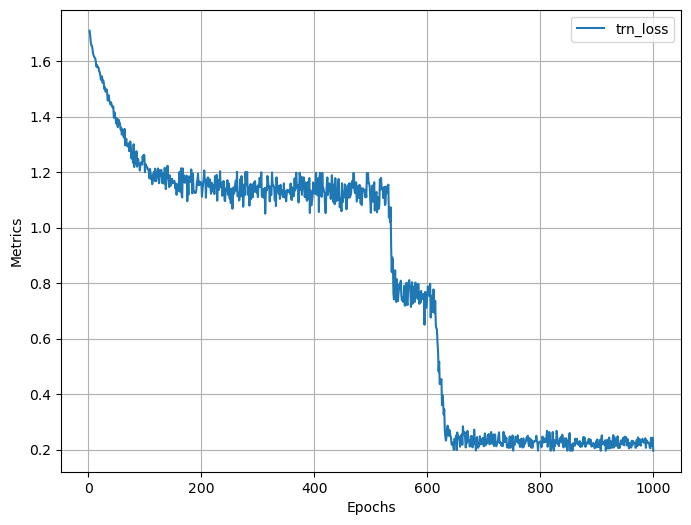

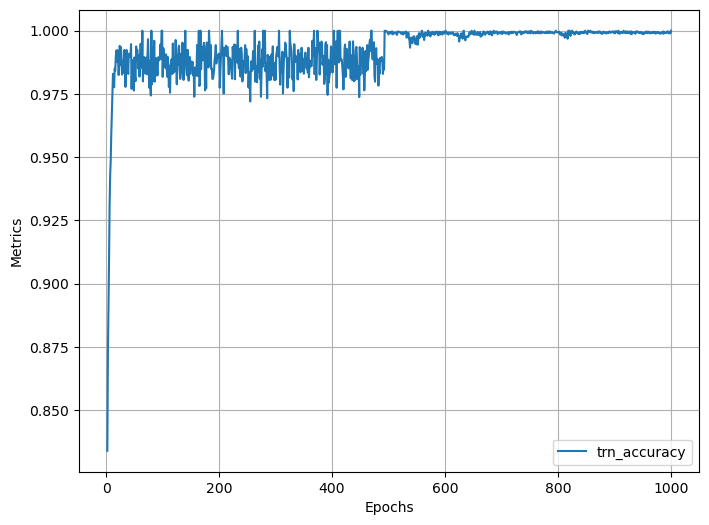

In [66]:
# Training with all training data
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_full_data".format(kernel_size))
)


train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
predict_and_evaluate(model=unet, data_loader=test_dataloader)

# Training with 10% of the training data

EPOCH: 1.000  trn_loss: 1.784  trn_accuracy: 0.296  (0.07s - 68.77s remaining)
EPOCH: 2.000  trn_loss: 1.774  trn_accuracy: 0.322  (0.11s - 55.18s remaining)
EPOCH: 3.000  trn_loss: 1.778  trn_accuracy: 0.357  (0.16s - 51.69s remaining)
EPOCH: 4.000  trn_loss: 1.767  trn_accuracy: 0.383  (0.20s - 48.81s remaining)
EPOCH: 5.000  trn_loss: 1.759  trn_accuracy: 0.423  (0.24s - 47.15s remaining)
EPOCH: 6.000  trn_loss: 1.759  trn_accuracy: 0.470  (0.27s - 45.42s remaining)
EPOCH: 7.000  trn_loss: 1.754  trn_accuracy: 0.515  (0.31s - 44.17s remaining)
EPOCH: 8.000  trn_loss: 1.750  trn_accuracy: 0.567  (0.35s - 43.20s remaining)
EPOCH: 9.000  trn_loss: 1.747  trn_accuracy: 0.580  (0.39s - 42.43s remaining)
EPOCH: 10.000  trn_loss: 1.744  trn_accuracy: 0.597  (0.42s - 41.77s remaining)
EPOCH: 11.000  trn_loss: 1.741  trn_accuracy: 0.631  (0.46s - 41.28s remaining)
EPOCH: 12.000  trn_loss: 1.738  trn_accuracy: 0.634  (0.50s - 40.87s remaining)
EPOCH: 13.000  trn_loss: 1.735  trn_accuracy: 0.6

EPOCH: 107.000  trn_loss: 1.592  trn_accuracy: 0.980  (4.14s - 34.57s remaining)
EPOCH: 108.000  trn_loss: 1.597  trn_accuracy: 0.982  (4.18s - 34.54s remaining)
EPOCH: 109.000  trn_loss: 1.587  trn_accuracy: 0.980  (4.22s - 34.50s remaining)
EPOCH: 110.000  trn_loss: 1.580  trn_accuracy: 0.983  (4.26s - 34.46s remaining)
EPOCH: 111.000  trn_loss: 1.584  trn_accuracy: 0.980  (4.30s - 34.44s remaining)
EPOCH: 112.000  trn_loss: 1.583  trn_accuracy: 0.983  (4.34s - 34.41s remaining)
EPOCH: 113.000  trn_loss: 1.580  trn_accuracy: 0.984  (4.38s - 34.37s remaining)
EPOCH: 114.000  trn_loss: 1.587  trn_accuracy: 0.981  (4.42s - 34.35s remaining)
EPOCH: 115.000  trn_loss: 1.582  trn_accuracy: 0.984  (4.46s - 34.32s remaining)
EPOCH: 116.000  trn_loss: 1.579  trn_accuracy: 0.982  (4.51s - 34.33s remaining)
EPOCH: 117.000  trn_loss: 1.580  trn_accuracy: 0.983  (4.54s - 34.29s remaining)
EPOCH: 118.000  trn_loss: 1.575  trn_accuracy: 0.983  (4.58s - 34.24s remaining)
EPOCH: 119.000  trn_loss: 1.

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.09it/s]


EPOCH: 201.000  trn_loss: 1.491  trn_accuracy: 0.990  (9.40s - 37.36s remaining)
EPOCH: 202.000  trn_loss: 1.489  trn_accuracy: 0.991  (9.44s - 37.28s remaining)
EPOCH: 203.000  trn_loss: 1.482  trn_accuracy: 0.991  (9.47s - 37.20s remaining)
EPOCH: 204.000  trn_loss: 1.489  trn_accuracy: 0.991  (9.51s - 37.12s remaining)
EPOCH: 205.000  trn_loss: 1.473  trn_accuracy: 0.991  (9.55s - 37.04s remaining)
EPOCH: 206.000  trn_loss: 1.474  trn_accuracy: 0.990  (9.59s - 36.96s remaining)
EPOCH: 207.000  trn_loss: 1.487  trn_accuracy: 0.991  (9.63s - 36.88s remaining)
EPOCH: 208.000  trn_loss: 1.484  trn_accuracy: 0.991  (9.67s - 36.80s remaining)
EPOCH: 209.000  trn_loss: 1.486  trn_accuracy: 0.991  (9.70s - 36.73s remaining)
EPOCH: 210.000  trn_loss: 1.486  trn_accuracy: 0.991  (9.74s - 36.65s remaining)
EPOCH: 211.000  trn_loss: 1.481  trn_accuracy: 0.991  (9.78s - 36.58s remaining)
EPOCH: 212.000  trn_loss: 1.474  trn_accuracy: 0.991  (9.82s - 36.50s remaining)
EPOCH: 213.000  trn_loss: 1.

EPOCH: 305.000  trn_loss: 1.372  trn_accuracy: 0.995  (13.61s - 31.01s remaining)
EPOCH: 306.000  trn_loss: 1.375  trn_accuracy: 0.996  (13.65s - 30.96s remaining)
EPOCH: 307.000  trn_loss: 1.373  trn_accuracy: 0.995  (13.69s - 30.90s remaining)
EPOCH: 308.000  trn_loss: 1.371  trn_accuracy: 0.996  (13.73s - 30.85s remaining)
EPOCH: 309.000  trn_loss: 1.381  trn_accuracy: 0.996  (13.77s - 30.79s remaining)
EPOCH: 310.000  trn_loss: 1.370  trn_accuracy: 0.995  (13.82s - 30.75s remaining)
EPOCH: 311.000  trn_loss: 1.364  trn_accuracy: 0.996  (13.87s - 30.72s remaining)
EPOCH: 312.000  trn_loss: 1.384  trn_accuracy: 0.996  (13.91s - 30.68s remaining)
EPOCH: 313.000  trn_loss: 1.375  trn_accuracy: 0.996  (13.96s - 30.65s remaining)
EPOCH: 314.000  trn_loss: 1.369  trn_accuracy: 0.996  (14.01s - 30.62s remaining)
EPOCH: 315.000  trn_loss: 1.381  trn_accuracy: 0.996  (14.06s - 30.58s remaining)
EPOCH: 316.000  trn_loss: 1.361  trn_accuracy: 0.996  (14.11s - 30.55s remaining)
EPOCH: 317.000  

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.43it/s]


EPOCH: 401.000  trn_loss: 1.298  trn_accuracy: 0.997  (19.13s - 28.58s remaining)
EPOCH: 402.000  trn_loss: 1.281  trn_accuracy: 0.997  (19.17s - 28.52s remaining)
EPOCH: 403.000  trn_loss: 1.296  trn_accuracy: 0.997  (19.21s - 28.46s remaining)
EPOCH: 404.000  trn_loss: 1.309  trn_accuracy: 0.997  (19.25s - 28.40s remaining)
EPOCH: 405.000  trn_loss: 1.277  trn_accuracy: 0.997  (19.29s - 28.34s remaining)
EPOCH: 406.000  trn_loss: 1.284  trn_accuracy: 0.997  (19.33s - 28.28s remaining)
EPOCH: 407.000  trn_loss: 1.286  trn_accuracy: 0.997  (19.37s - 28.23s remaining)
EPOCH: 408.000  trn_loss: 1.274  trn_accuracy: 0.997  (19.41s - 28.17s remaining)
EPOCH: 409.000  trn_loss: 1.287  trn_accuracy: 0.997  (19.46s - 28.11s remaining)
EPOCH: 410.000  trn_loss: 1.272  trn_accuracy: 0.997  (19.50s - 28.05s remaining)
EPOCH: 411.000  trn_loss: 1.271  trn_accuracy: 0.997  (19.53s - 27.99s remaining)
EPOCH: 412.000  trn_loss: 1.288  trn_accuracy: 0.998  (19.57s - 27.93s remaining)
EPOCH: 413.000  

EPOCH: 502.000  trn_loss: 1.176  trn_accuracy: 0.998  (23.64s - 23.45s remaining)
EPOCH: 503.000  trn_loss: 1.191  trn_accuracy: 0.999  (23.69s - 23.41s remaining)
EPOCH: 504.000  trn_loss: 1.195  trn_accuracy: 0.998  (23.74s - 23.36s remaining)
EPOCH: 505.000  trn_loss: 1.166  trn_accuracy: 0.998  (23.79s - 23.32s remaining)
EPOCH: 506.000  trn_loss: 1.172  trn_accuracy: 0.998  (23.84s - 23.27s remaining)
EPOCH: 507.000  trn_loss: 1.193  trn_accuracy: 0.998  (23.89s - 23.23s remaining)
EPOCH: 508.000  trn_loss: 1.173  trn_accuracy: 0.999  (23.94s - 23.18s remaining)
EPOCH: 509.000  trn_loss: 1.154  trn_accuracy: 0.998  (23.98s - 23.13s remaining)
EPOCH: 510.000  trn_loss: 1.190  trn_accuracy: 0.999  (24.03s - 23.09s remaining)
EPOCH: 511.000  trn_loss: 1.174  trn_accuracy: 0.998  (24.08s - 23.04s remaining)
EPOCH: 512.000  trn_loss: 1.194  trn_accuracy: 0.999  (24.12s - 22.99s remaining)
EPOCH: 513.000  trn_loss: 1.175  trn_accuracy: 0.999  (24.17s - 22.95s remaining)
EPOCH: 514.000  

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.05it/s]


EPOCH: 601.000  trn_loss: 1.128  trn_accuracy: 0.999  (28.90s - 19.18s remaining)
EPOCH: 602.000  trn_loss: 1.115  trn_accuracy: 0.999  (28.94s - 19.13s remaining)
EPOCH: 603.000  trn_loss: 1.149  trn_accuracy: 0.999  (28.97s - 19.08s remaining)
EPOCH: 604.000  trn_loss: 1.119  trn_accuracy: 0.999  (29.01s - 19.02s remaining)
EPOCH: 605.000  trn_loss: 1.076  trn_accuracy: 0.999  (29.05s - 18.97s remaining)
EPOCH: 606.000  trn_loss: 1.092  trn_accuracy: 0.999  (29.09s - 18.91s remaining)
EPOCH: 607.000  trn_loss: 1.110  trn_accuracy: 0.999  (29.13s - 18.86s remaining)
EPOCH: 608.000  trn_loss: 1.094  trn_accuracy: 0.999  (29.17s - 18.81s remaining)
EPOCH: 609.000  trn_loss: 1.117  trn_accuracy: 0.999  (29.21s - 18.75s remaining)
EPOCH: 610.000  trn_loss: 1.112  trn_accuracy: 0.999  (29.25s - 18.70s remaining)
EPOCH: 611.000  trn_loss: 1.103  trn_accuracy: 0.999  (29.28s - 18.64s remaining)
EPOCH: 612.000  trn_loss: 1.115  trn_accuracy: 0.999  (29.32s - 18.59s remaining)
EPOCH: 613.000  

EPOCH: 705.000  trn_loss: 1.071  trn_accuracy: 0.999  (33.34s - 13.95s remaining)
EPOCH: 706.000  trn_loss: 1.077  trn_accuracy: 0.999  (33.39s - 13.90s remaining)
EPOCH: 707.000  trn_loss: 1.097  trn_accuracy: 0.999  (33.44s - 13.86s remaining)
EPOCH: 708.000  trn_loss: 1.080  trn_accuracy: 0.999  (33.49s - 13.81s remaining)
EPOCH: 709.000  trn_loss: 1.077  trn_accuracy: 0.999  (33.54s - 13.77s remaining)
EPOCH: 710.000  trn_loss: 1.064  trn_accuracy: 0.999  (33.59s - 13.72s remaining)
EPOCH: 711.000  trn_loss: 1.065  trn_accuracy: 0.999  (33.65s - 13.68s remaining)
EPOCH: 712.000  trn_loss: 1.036  trn_accuracy: 0.999  (33.70s - 13.63s remaining)
EPOCH: 713.000  trn_loss: 1.017  trn_accuracy: 0.999  (33.75s - 13.59s remaining)
EPOCH: 714.000  trn_loss: 1.119  trn_accuracy: 0.999  (33.80s - 13.54s remaining)
EPOCH: 715.000  trn_loss: 1.043  trn_accuracy: 0.999  (33.86s - 13.49s remaining)
EPOCH: 716.000  trn_loss: 1.075  trn_accuracy: 0.999  (33.90s - 13.45s remaining)
EPOCH: 717.000  

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.53it/s]


EPOCH: 801.000  trn_loss: 1.045  trn_accuracy: 0.999  (39.50s - 9.81s remaining)
EPOCH: 802.000  trn_loss: 1.021  trn_accuracy: 0.999  (39.54s - 9.76s remaining)
EPOCH: 803.000  trn_loss: 1.063  trn_accuracy: 0.999  (39.58s - 9.71s remaining)
EPOCH: 804.000  trn_loss: 1.064  trn_accuracy: 0.999  (39.62s - 9.66s remaining)
EPOCH: 805.000  trn_loss: 1.053  trn_accuracy: 0.999  (39.66s - 9.61s remaining)
EPOCH: 806.000  trn_loss: 1.062  trn_accuracy: 0.999  (39.70s - 9.56s remaining)
EPOCH: 807.000  trn_loss: 1.063  trn_accuracy: 0.999  (39.74s - 9.50s remaining)
EPOCH: 808.000  trn_loss: 1.033  trn_accuracy: 0.999  (39.78s - 9.45s remaining)
EPOCH: 809.000  trn_loss: 1.038  trn_accuracy: 0.999  (39.82s - 9.40s remaining)
EPOCH: 810.000  trn_loss: 1.086  trn_accuracy: 0.999  (39.86s - 9.35s remaining)
EPOCH: 811.000  trn_loss: 1.086  trn_accuracy: 0.999  (39.90s - 9.30s remaining)
EPOCH: 812.000  trn_loss: 1.019  trn_accuracy: 0.999  (39.94s - 9.25s remaining)
EPOCH: 813.000  trn_loss: 0.

EPOCH: 908.000  trn_loss: 1.049  trn_accuracy: 0.999  (44.17s - 4.48s remaining)
EPOCH: 909.000  trn_loss: 1.046  trn_accuracy: 0.999  (44.21s - 4.43s remaining)
EPOCH: 910.000  trn_loss: 0.968  trn_accuracy: 0.999  (44.24s - 4.38s remaining)
EPOCH: 911.000  trn_loss: 1.062  trn_accuracy: 0.999  (44.28s - 4.33s remaining)
EPOCH: 912.000  trn_loss: 0.980  trn_accuracy: 0.999  (44.32s - 4.28s remaining)
EPOCH: 913.000  trn_loss: 1.058  trn_accuracy: 0.999  (44.36s - 4.23s remaining)
EPOCH: 914.000  trn_loss: 1.023  trn_accuracy: 0.999  (44.40s - 4.18s remaining)
EPOCH: 915.000  trn_loss: 1.013  trn_accuracy: 0.999  (44.44s - 4.13s remaining)
EPOCH: 916.000  trn_loss: 0.997  trn_accuracy: 0.999  (44.48s - 4.08s remaining)
EPOCH: 917.000  trn_loss: 1.013  trn_accuracy: 0.999  (44.52s - 4.03s remaining)
EPOCH: 918.000  trn_loss: 1.048  trn_accuracy: 0.999  (44.55s - 3.98s remaining)
EPOCH: 919.000  trn_loss: 1.001  trn_accuracy: 0.999  (44.59s - 3.93s remaining)
EPOCH: 920.000  trn_loss: 1.

100%|███████████████████████████████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 33425.71it/s]
20it [00:00, 214.95it/s]


[INFO] Avg Accuracy: 0.9886457324028015 +/- 0.008092152886092663
[INFO] Avg Dice: 0.3697600825300243 +/- 0.3915885066141083


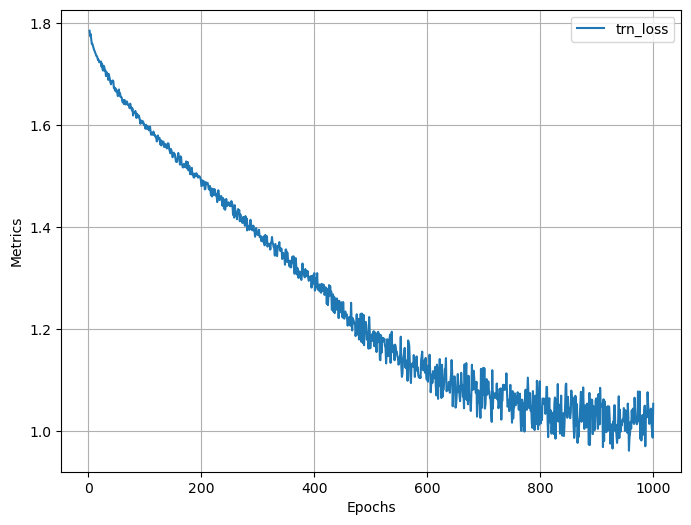

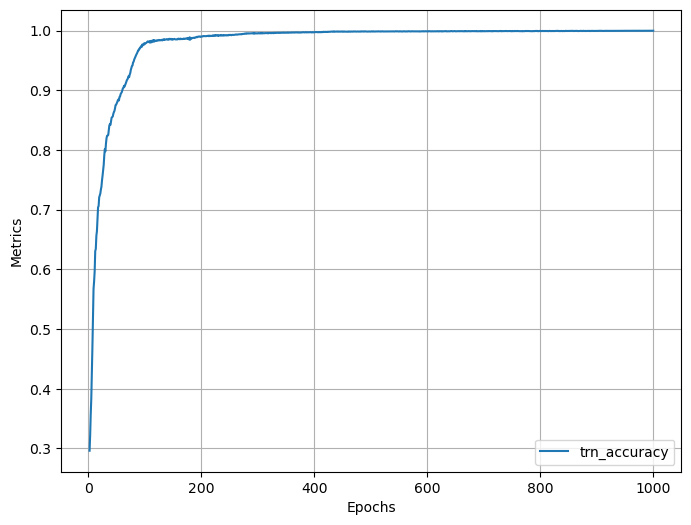

In [67]:
# Training with all training data
n_reduced_data = int(0.10 * len(train_images))
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images[:n_reduced_data],
    labels=train_labels[:n_reduced_data],
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_reduced_data".format(kernel_size))
)


train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
predict_and_evaluate(model=unet, data_loader=test_dataloader)